### Acquiring and processing data ###

In [3]:
import json
import pandas as pd
import re

input_file = 'C:\\Users\\rohit\\Desktop\\HiWi\Work\\Radar Sensor Project\\py_mmwave_dev\\py_mmwave_plot\\log\\test_node_x_mmwave_sensor_20240729_105845.txt'

match = re.search(r'sensor_(\d{8}_\d{6})', input_file)
if match:
    timestamp_part = match.group(1)
else:
    raise ValueError("No timestamp found in the input file path")

#output_file = f'{timestamp_part}_parsed_data.csv'


#Initializing
data_list = []

#Read data file and parse the JSON data
with open(input_file, 'r') as file:
    for line in file:
        data = json.loads(line.strip())
        timestamp = data['timestamp']
        numObj = data['numObj']
        
        # Create a row for each object
        for i in range(numObj):
            row = {
                'timestamp': timestamp,
                'range': data['range'][i],
                'azimuth': data['azimuth'][i],
                'elevation': data['elevation'][i],
                'x': data['x'][i],
                'y': data['y'][i],
                'z': data['z'][i],
                'v': data['v'][i],
                'snr': data['snr'][i],
                'rangeProfile': data['rangeProfile'],
            }
            data_list.append(row)

#list of dictionaries to pandas DataFrame
df = pd.DataFrame(data_list)

#Displaying DataFrame
print(df.head())

#CSV output of DataFrame
#df.to_csv(output_file, index=False)

print(df.timestamp)
print(df.range)
print(df.azimuth)

      timestamp     range    azimuth  elevation      x      y      z    v  \
0  1.722244e+09  0.087407 -69.904769   2.622936 -0.082  0.030  0.004  0.0   
1  1.722244e+09  0.436304  22.702842  13.114990  0.164  0.392  0.099  0.0   
2  1.722244e+09  0.697620 -64.978144  -1.232050 -0.632  0.295 -0.015  0.0   
3  1.722244e+09  0.916068 -57.948002   5.386830 -0.773  0.484  0.086  0.0   
4  1.722244e+09  0.915901  10.831149  -2.064820  0.172  0.899 -0.033  0.0   

    snr                                       rangeProfile  
0  19.1  [26.136, 33.427, 36.531, 35.904, 31.812, 25.16...  
1   5.5  [26.136, 33.427, 36.531, 35.904, 31.812, 25.16...  
2   3.9  [26.136, 33.427, 36.531, 35.904, 31.812, 25.16...  
3   6.5  [26.136, 33.427, 36.531, 35.904, 31.812, 25.16...  
4   6.5  [26.136, 33.427, 36.531, 35.904, 31.812, 25.16...  
0         1.722244e+09
1         1.722244e+09
2         1.722244e+09
3         1.722244e+09
4         1.722244e+09
              ...     
154657    1.722244e+09
154658    

### Visualizing the Radar PtCloud Data ###

#### Interpolated Count based 2D Histogram ####

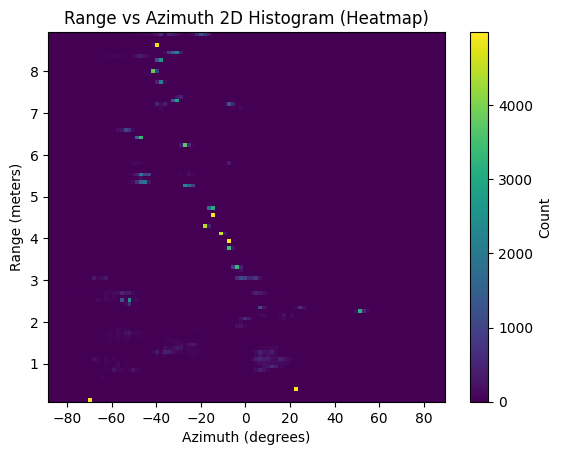

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.hist2d(df['azimuth'], df['range'], bins=[100, 100], cmap='viridis')

plt.colorbar(label='Count')

plt.xlabel('Azimuth (degrees)')
plt.ylabel('Range (meters)')
plt.title('Range vs Azimuth 2D Histogram (Heatmap)')

plt.show()

#### Interpolated SNR-based Azimuth-Range Heatmap ####

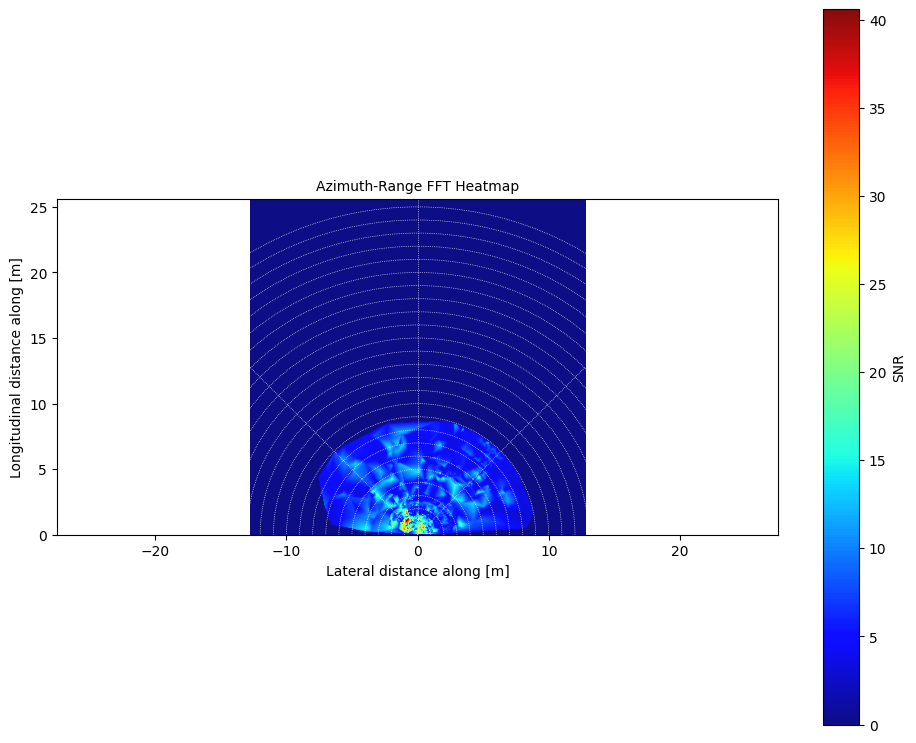

In [5]:
import scipy.interpolate as spi
import matplotlib.patches as pat
import matplotlib.widgets as wgt
#other libraries already imported previously

#Parameters
tx_azimuth_antennas = 4  
rx_antennas = 3  
range_bins = 256
angle_bins = 64
range_res = 0.1  
range_bias = 0.0 

#coordinates
t = np.linspace(-1, 1, angle_bins)
t = np.arcsin(t)
r = np.linspace(0, range_bins * range_res, range_bins)

range_depth = range_bins * range_res
range_width, grid_res = range_depth / 2, 400

xi = np.linspace(-range_width, range_width, grid_res)
yi = np.linspace(0, range_depth, grid_res)
xi, yi = np.meshgrid(xi, yi)

# x & y values for bins
x = np.outer(r, np.sin(t))
y = np.outer(r, np.cos(t))
y = y - range_bias

#Interpolating
azimuth_radians = np.radians(df['azimuth'])
x_points = df['range'] * np.sin(azimuth_radians)
y_points = df['range'] * np.cos(azimuth_radians)
values = df['snr']

#Interpolating with SNR values
zi = spi.griddata((x_points, y_points), values, (xi, yi), method='linear')
zi = np.nan_to_num(zi)  # Replace NaN values with zero

#Plot
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)

fig.tight_layout(pad=2)

cm = ax.imshow(zi[::-1, ::-1], cmap=plt.cm.jet, extent=[-range_width, range_width, 0, range_depth], alpha=0.95)
cursor = wgt.Cursor(ax, useblit=True, color='white', linewidth=1)

ax.set_title('Azimuth-Range FFT Heatmap', fontsize=10)
ax.set_xlabel('Lateral distance along [m]')
ax.set_ylabel('Longitudinal distance along [m]')

ax.plot([0, 0], [0, range_depth], color='white', linewidth=0.5, linestyle=':', zorder=1)
ax.plot([0, -range_width], [0, range_width], color='white', linewidth=0.5, linestyle=':', zorder=1)
ax.plot([0, +range_width], [0, range_width], color='white', linewidth=0.5, linestyle=':', zorder=1)

# Range circles
for i in range(1, int(range_depth)+1):
    ax.add_patch(pat.Arc((0, 0), width=i*2, height=i*2, angle=90, theta1=-90, theta2=90, color='white', linewidth=0.5, linestyle=':', zorder=1))

plt.colorbar(cm, ax=ax, label='SNR')
plt.show() 

#### 3D PtCloud Plot without Interpolation, based on SNR values ####

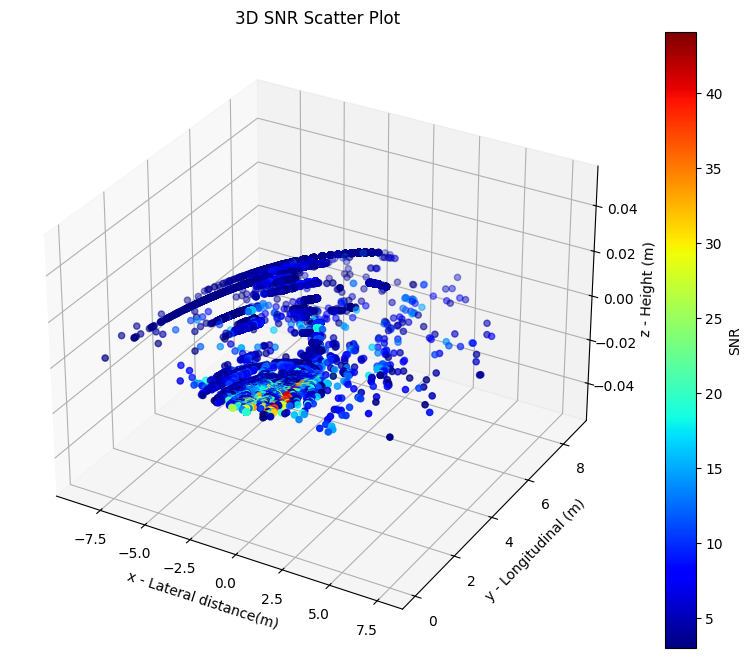

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

assert all(col in df.columns for col in ['azimuth', 'range', 'snr']), "Dataframe must contain 'azimuth', 'range', and 'snr' columns."

# Parameters for transformation
range_res = 0.1
range_bias = 0.0

# Convert azimuth to radians and calculate x, y, z coordinates
azimuth_radians = np.radians(df['azimuth'])
ranges = df['range']
snr = df['snr']

x = ranges * np.sin(azimuth_radians)
y = ranges * np.cos(azimuth_radians) - range_bias
z = np.zeros_like(x)  # Flat on the z-axis since we're only showing (x, y) and coloring by SNR

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with SNR values for color
sc = ax.scatter(x, y, z, c=snr, cmap='jet', marker='o')

# Colorbar to show SNR scale
plt.colorbar(sc, label='SNR')

# Labels and title
ax.set_title('3D SNR Scatter Plot')
ax.set_xlabel('x - Lateral distance(m)')
ax.set_ylabel('y - Longitudinal (m)')
ax.set_zlabel('z - Height (m)')  

plt.show()

#### RangeProfile ####

8.939919071222064


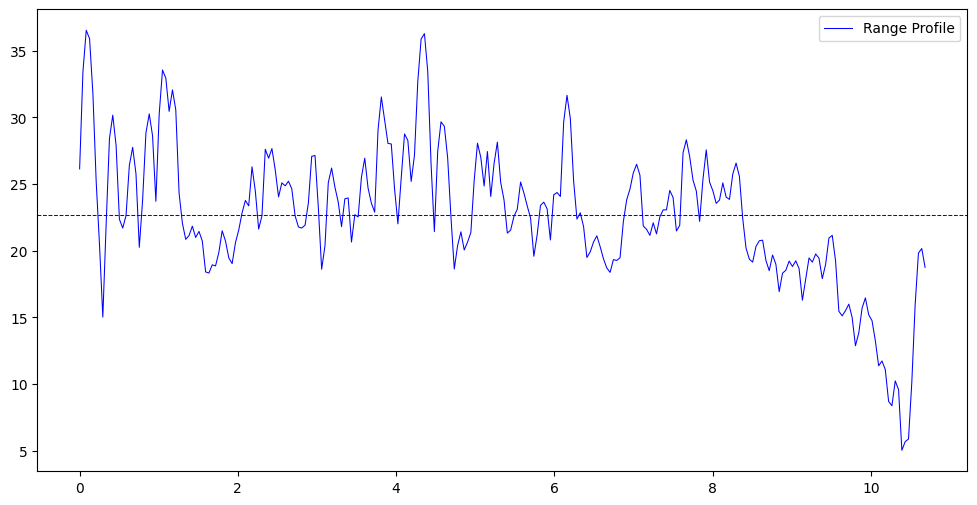

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def update(df, range_max=100, range_bias=0):
    ax.clear()

    if 'rangeProfile' in df.columns:
        y = df['rangeProfile'].values[0]  # Assuming you're interested in the first row for simplicity
        bin_size = range_max / len(y)
        x = [i * bin_size for i in range(len(y))]
        x = [v - range_bias for v in x]
        ax.plot(x, y, color='blue', linewidth=0.75, label='Range Profile')
        ax.axhline(y=np.mean(y), color='blue', linestyle='--', linewidth=0.75)
      
    ax.legend()

# Plotting data
def start_plot(df, range_bias=0):
    fig = plt.figure(figsize=(12, 6))
    global ax
    ax = plt.subplot(1, 1, 1)
    
    fig.canvas.manager.set_window_title('Range Profile')
                           
    ax.set_title('Range Profile', fontsize=10)
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Relative power [dB]')
    
    # value for max range plot
    max_range_value = df['range'].max()
    print(max_range_value)
    range_max = max_range_value * 1.2  # Adding 20% buffer to range values
    
    ax.set_xlim([0, range_max])
    ax.set_ylim([0, 100])
    ax.set_yticks(range(0, 101, 10))
    ax.grid(linestyle=':')
    
    update(df, range_max, range_bias)
    
    plt.show()

start_plot(df)